# Focal Loss

Loss On Binary Classification
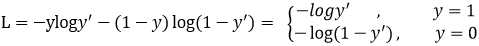

Focal Loss on Binary Classification
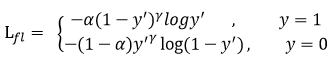

Loss On Softmax Classification
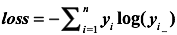

Focal Loss On Softmax Classification

In [2]:
import tensorflow as tf
from tensorflow.keras import *
import numpy as np

print(tf.__version__)
print(tf.keras.__version__)
print(np.__version__)

2.1.0
2.2.4-tf
1.18.1


# Focal Loss on Binary Classfication

In [4]:
mnist = datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = np.where(y_train > 0, 1.0, 0.0), np.where(y_test > 0, 1.0, 0.0)

In [ ]:
import numpy as np

# Model
model = Sequential([
    layers.Reshape([28, 28, 1], input_shape=(28,28), name='repshape'),
    layers.Conv2D(32, 3, 1, name='conv1'),
    layers.BatchNormalization(name='bn1'),
    layers.Activation(activation='relu', name='relu1'),
    layers.Conv2D(64, 3, 1, name='conv2'),
    layers.BatchNormalization(name='bn2'),
    layers.Activation(activation='relu', name='relu2'),
    layers.Conv2D(128, 3, 1, name='conv3'),
    layers.BatchNormalization(name='bn3'),
    layers.Activation(activation='relu', name='relu3'),
    layers.GlobalAveragePooling2D(name='gap'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

        
class binary_accuracy(metrics.Metric):
    def __init__(self, name='binary_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.acc_numerator = self.add_weight(name="acc_numerator", initializer='zeros')
        self.acc_denominator = self.add_weight(name="acc_denominator", initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred >= 0.5, tf.int32)
        y_true = tf.reshape(tf.cast(y_true, tf.int32), [-1])
        self.acc_numerator.assign_add(tf.reduce_sum(tf.cast(y_pred == y_true, tf.float32)))
        self.acc_denominator.assign_add(tf.cast(tf.shape(y_pred)[0], tf.float32))

    def result(self):
        return self.acc_numerator / self.acc_denominator
        
    def reset_states(self):
        self.acc_numerator.assign(0.)
        self.acc_denominator.assign(0.)
        
        
def log_loss(y_actual, y_pred):
    log = lambda x : tf.math.log(tf.math.maximum(x, 1e-7)) # prevent log(0) causing nan
    loss = - (y_actual) * log(y_pred) - (1 - y_actual) * log(1 - y_pred)
    return loss

def focal_loss(y_actual, y_pred):
    log = lambda x : tf.math.log(tf.math.maximum(x, 1e-7)) # prevent log(0) causing nan
    alpha, gamma = 0.25, 2
    loss = - alpha * y_actual * tf.math.pow(1 - y_pred, gamma) * log(y_pred) \
            - (1 - alpha) * (1 - y_actual) * tf.math.pow(y_pred, gamma) * log(1 - y_pred)
    return loss

model.compile(optimizer=optimizers.Adam(1e-4), loss=log_loss, metrics=[binary_accuracy()])
model.fit(x_train, y_train, validation_split=0.2, epochs = 5)

model.compile(optimizer=optimizers.Adam(1e-4), loss=focal_loss, metrics=[binary_accuracy()])
model.fit(x_train, y_train, validation_split=0.2, epochs = 5)


In [ ]:
model.evaluate(x_test, y_test)

# Focal Loss on Multiclass  Classfication

In [ ]:
mnist = datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.astype(np.float32), y_test.astype(np.float32)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
#y_train, y_test = np.where(y_train > 0, 1.0, 0.0), np.where(y_test > 0, 1.0, 0.0)

In [6]:
import numpy as np

# Model
model = Sequential([
    layers.Reshape([28, 28, 1], input_shape=(28,28), name='repshape'),
    layers.Conv2D(16, 3, 1, name='conv1'),
    layers.BatchNormalization(name='bn1'),
    layers.Activation(activation='relu', name='relu1'),
    layers.Conv2D(32, 3, 1, name='conv2'),
    layers.BatchNormalization(name='bn2'),
    layers.Activation(activation='relu', name='relu2'),
    layers.Conv2D(64, 3, 1, name='conv3'),
    layers.BatchNormalization(name='bn3'),
    layers.Activation(activation='relu', name='relu3'),
    layers.Flatten(name='flat4'),
    layers.Dense(10, activation='softmax')
])
#model.summary()


class multiclass_accuracy(metrics.Metric):
    def __init__(self, name='multiclass_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.acc_numerator = self.add_weight(name="acc_numerator", initializer='zeros')
        self.acc_denominator = self.add_weight(name="acc_denominator", initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.math.argmax(y_pred, -1), tf.int32)
        y_true = tf.reshape(tf.cast(y_true, tf.int32), [-1])
        self.acc_numerator.assign_add(tf.math.reduce_sum(tf.cast(y_pred == y_true, tf.float32)))
        self.acc_denominator.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        return self.acc_numerator / self.acc_denominator
        
    def reset_states(self):
        self.acc_numerator.assign(0.)
        self.acc_denominator.assign(0.)
        
        
def log_loss(y_true, y_pred):
    log = lambda x : tf.math.log(tf.math.maximum(x, 1e-7)) # prevent log(0) causing nan
    
    classes_num, batch_size = tf.shape(y_pred)[1], tf.shape(y_pred)[0]
    y_pred = tf.reshape(y_pred, [-1])  # [batch_size * n_class]
    y_true = tf.reshape(tf.cast(y_true, tf.int32), [-1])
    y_true_idx = tf.reshape(tf.range(0, batch_size) * classes_num + y_true, [-1])
    loss = - log(tf.gather(y_pred, y_true_idx))
    return loss

def focal_loss(y_true, y_pred, alpha = [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1]], epsilon = 1e-7, gamma=2.0):
    log = lambda x : tf.math.log(tf.math.maximum(x, 1e-7)) # prevent log(0) causing nan
    
    # Each label has an alpha

    classes_num, batch_size = tf.shape(y_pred)[1], tf.shape(y_pred)[0]
    y_pred = tf.reshape(y_pred, [-1])  # [batch_size * n_class]
    y_true = tf.reshape(tf.cast(y_true, tf.int32), [-1]) # [batch_size]
    y_true_idx = tf.reshape(tf.range(0, batch_size) * classes_num + y_true, [-1])

    y_prob = tf.gather(y_pred, y_true_idx)
    
    weight = tf.gather(tf.constant(alpha, tf.float32), y_true) * tf.pow(1. - y_prob, gamma)
    
    loss = weight * (- log(y_prob))
    return loss

#model.compile(optimizer=optimizers.Adam(1e-3), loss=log_loss, metrics=[multiclass_accuracy()])
#model.fit(x_train, y_train, validation_split=0.2, epochs = 5)

model.compile(optimizer=optimizers.Adam(1e-3), loss=focal_loss, metrics=[multiclass_accuracy()])
model.fit(x_train, y_train, validation_split=0.2, epochs = 5)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 9s 188us/sample - loss: 0.0813 - multiclass_accuracy: 0.9886


KeyboardInterrupt: 

In [ ]:
model.evaluate(x_test, y_test)